# Детектирование аномалий в многомерных временных рядах с помощью Ruptures

Этот ноутбук использует библиотеку Ruptures для обнаружения точек изменения (change points) в многомерных временных рядах, которые можно интерпретировать как аномалии.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
import warnings
import os
from pathlib import Path
from typing import List, Dict, Tuple
from sklearn.preprocessing import StandardScaler
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")


## Настройка путей и загрузка данных


In [2]:
# Пути к данным
data_path = Path('../data/series')
output_path = Path('../data/series_with_anomaly')

# Получаем список всех CSV файлов
csv_files = list(data_path.glob('*.csv'))
print(f"Найдено {len(csv_files)} файлов с временными рядами:")
for file in csv_files:
    print(f"  - {file.name}")


Найдено 10 файлов с временными рядами:
  - AFLT.csv
  - LKOH.csv
  - MOEX.csv
  - NVTK.csv
  - PIKK.csv
  - SBER.csv
  - VKCO.csv
  - VTBR.csv
  - X5.csv
  - YDEX.csv


## Функции для детектирования аномалий


In [3]:
def load_and_preprocess_data(file_path: Path) -> pd.DataFrame:
    """
    Загружает и предобрабатывает данные временного ряда
    """
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Удаляем дубликаты по индексу, если есть
    df = df[~df.index.duplicated(keep='first')]
    
    # Заполняем пропуски методом forward fill
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    
    return df

def detect_anomalies_ruptures(data: np.ndarray, 
                             method: str = 'pelt',
                             model: str = 'l2',
                             min_size: int = 10,
                             jump: int = 1) -> List[int]:
    """
    Детектирует точки изменения в многомерных временных рядах
    
    Parameters:
    -----------
    data : np.ndarray
        Многомерные временные ряды (n_samples, n_features)
    method : str
        Метод детектирования ('pelt', 'binseg', 'window')
    model : str
        Модель изменения ('l1', 'l2', 'rbf', 'linear', 'normal', 'ar')
    min_size : int
        Минимальный размер сегмента
    jump : int
        Шаг поиска
    
    Returns:
    --------
    List[int] : список индексов точек изменения
    """
    
    # Нормализация данных
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    if method == 'pelt':
        algo = rpt.Pelt(model=model, min_size=min_size, jump=jump)
        result = algo.fit_predict(data_scaled, pen=10)
    elif method == 'binseg':
        algo = rpt.Binseg(model=model, min_size=min_size, jump=jump)
        result = algo.fit_predict(data_scaled, n_bkps=10)  # максимум 10 точек изменения
    elif method == 'window':
        algo = rpt.Window(width=50, model=model, min_size=min_size, jump=jump)
        result = algo.fit_predict(data_scaled, pen=10)
    else:
        raise ValueError(f"Неизвестный метод: {method}")
    
    # Удаляем последний элемент (длина ряда)
    if result and result[-1] == len(data_scaled):
        result = result[:-1]
    
    return result

def create_anomaly_labels(length: int, change_points: List[int], window: int = 5) -> np.ndarray:
    """
    Создает метки аномалий на основе точек изменения
    
    Parameters:
    -----------
    length : int
        Длина временного ряда
    change_points : List[int]
        Список индексов точек изменения
    window : int
        Размер окна вокруг точки изменения для маркировки как аномалия
    
    Returns:
    --------
    np.ndarray : бинарные метки аномалий (1 - аномалия, 0 - норма)
    """
    labels = np.zeros(length)
    
    for cp in change_points:
        # Создаем окно вокруг точки изменения
        start = max(0, cp - window)
        end = min(length, cp + window + 1)
        labels[start:end] = 1
    
    return labels


## Визуализация результатов


In [4]:
def plot_anomalies(df: pd.DataFrame, change_points: List[int], 
                   anomaly_labels: np.ndarray, ticker: str):
    """
    Визуализирует временной ряд с обнаруженными аномалиями
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f'Детектирование аномалий для {ticker}', fontsize=16)
    
    # Цены закрытия с аномалиями
    axes[0, 0].plot(df.index, df['close'], label='Close Price', alpha=0.7)
    anomaly_mask = anomaly_labels.astype(bool)
    axes[0, 0].scatter(df.index[anomaly_mask], df['close'][anomaly_mask], 
                      color='red', s=20, alpha=0.6, label='Аномалии')
    
    # Добавляем вертикальные линии для точек изменения
    for cp in change_points:
        axes[0, 0].axvline(x=df.index[cp], color='red', linestyle='--', alpha=0.5)
    
    axes[0, 0].set_title('Цена закрытия с аномалиями')
    axes[0, 0].set_ylabel('Цена')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Объем торгов с аномалиями
    axes[0, 1].plot(df.index, df['volume'], label='Volume', alpha=0.7)
    axes[0, 1].scatter(df.index[anomaly_mask], df['volume'][anomaly_mask], 
                      color='red', s=20, alpha=0.6, label='Аномалии')
    
    for cp in change_points:
        axes[0, 1].axvline(x=df.index[cp], color='red', linestyle='--', alpha=0.5)
    
    axes[0, 1].set_title('Объем торгов с аномалиями')
    axes[0, 1].set_ylabel('Объем')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Волатильность (high-low) с аномалиями
    volatility = df['high'] - df['low']
    axes[1, 0].plot(df.index, volatility, label='Volatility (High-Low)', alpha=0.7)
    axes[1, 0].scatter(df.index[anomaly_mask], volatility[anomaly_mask], 
                      color='red', s=20, alpha=0.6, label='Аномалии')
    
    for cp in change_points:
        axes[1, 0].axvline(x=df.index[cp], color='red', linestyle='--', alpha=0.5)
    
    axes[1, 0].set_title('Волатильность с аномалиями')
    axes[1, 0].set_ylabel('High - Low')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Дневная доходность с аномалиями
    daily_return = df['close'].pct_change().dropna()
    axes[1, 1].plot(df.index[1:], daily_return, label='Daily Return', alpha=0.7)
    axes[1, 1].scatter(df.index[1:][anomaly_mask[1:]], daily_return[anomaly_mask[1:]], 
                      color='red', s=20, alpha=0.6, label='Аномалии')
    
    for cp in change_points:
        if cp > 0:
            axes[1, 1].axvline(x=df.index[cp], color='red', linestyle='--', alpha=0.5)
    
    axes[1, 1].set_title('Дневная доходность с аномалиями')
    axes[1, 1].set_ylabel('Доходность')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Метки аномалий
    axes[2, 0].plot(df.index, anomaly_labels, label='Метки аномалий', linewidth=2)
    axes[2, 0].fill_between(df.index, 0, anomaly_labels, alpha=0.3, color='red')
    axes[2, 0].set_title('Бинарные метки аномалий')
    axes[2, 0].set_ylabel('Аномалия (1/0)')
    axes[2, 0].set_ylim(-0.1, 1.1)
    axes[2, 0].grid(True, alpha=0.3)
    
    # Статистика аномалий
    total_points = len(anomaly_labels)
    anomaly_points = np.sum(anomaly_labels)
    anomaly_percentage = (anomaly_points / total_points) * 100
    
    stats_text = f"""Статистика аномалий:
Общее количество точек: {total_points}
Аномальных точек: {int(anomaly_points)}
Процент аномалий: {anomaly_percentage:.2f}%
Количество точек изменения: {len(change_points)}"""
    
    axes[2, 1].text(0.1, 0.5, stats_text, fontsize=12, 
                    transform=axes[2, 1].transAxes, verticalalignment='center')
    axes[2, 1].set_title('Статистика')
    axes[2, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig


## Обработка всех временных рядов


In [5]:
def process_time_series(file_path: Path, 
                       methods: List[str] = ['pelt', 'binseg'],
                       models: List[str] = ['l2', 'rbf']) -> Dict:
    """
    Обрабатывает один временной ряд различными методами
    """
    ticker = file_path.stem
    print(f"\nОбработка {ticker}...")
    
    # Загружаем данные
    df = load_and_preprocess_data(file_path)
    
    # Подготавливаем многомерные данные (OHLCV)
    features = ['open', 'high', 'low', 'close', 'volume']
    data_matrix = df[features].values
    
    results = {}
    
    # Пробуем разные комбинации методов и моделей
    for method in methods:
        for model in models:
            try:
                print(f"  Метод: {method}, Модель: {model}")
                
                # Детектируем аномалии
                change_points = detect_anomalies_ruptures(
                    data_matrix, method=method, model=model
                )
                
                # Создаем метки аномалий
                anomaly_labels = create_anomaly_labels(
                    len(df), change_points, window=3
                )
                
                # Сохраняем результаты
                key = f"{method}_{model}"
                results[key] = {
                    'change_points': change_points,
                    'anomaly_labels': anomaly_labels,
                    'anomaly_percentage': (np.sum(anomaly_labels) / len(anomaly_labels)) * 100
                }
                
                print(f"    Найдено {len(change_points)} точек изменения")
                print(f"    Процент аномалий: {results[key]['anomaly_percentage']:.2f}%")
                
            except Exception as e:
                print(f"    Ошибка: {e}")
                continue
    
    # Выбираем лучший результат (с разумным процентом аномалий)
    best_key = None
    best_score = float('inf')
    
    for key, result in results.items():
        # Ищем результат с процентом аномалий от 1% до 15%
        percentage = result['anomaly_percentage']
        if 1 <= percentage <= 15:
            # Предпочитаем результаты ближе к 5%
            score = abs(percentage - 5)
            if score < best_score:
                best_score = score
                best_key = key
    
    # Если не найден хороший результат, берем первый доступный
    if best_key is None and results:
        best_key = list(results.keys())[0]
    
    if best_key:
        print(f"  Выбран лучший результат: {best_key}")
        
        # Визуализируем результат
        best_result = results[best_key]
        plot_anomalies(df, best_result['change_points'], 
                      best_result['anomaly_labels'], ticker)
        
        # Сохраняем данные с аномалиями
        df_with_anomalies = df.copy()
        df_with_anomalies['anomaly'] = best_result['anomaly_labels']
        df_with_anomalies['method'] = best_key
        
        output_file = output_path / f"{ticker}_with_anomalies.csv"
        df_with_anomalies.to_csv(output_file)
        print(f"  Результат сохранен в {output_file}")
        
        return {
            'ticker': ticker,
            'method': best_key,
            'change_points_count': len(best_result['change_points']),
            'anomaly_percentage': best_result['anomaly_percentage'],
            'data_length': len(df)
        }
    
    print(f"  Не удалось обработать {ticker}")
    return None


## Запуск обработки всех файлов



Обработка AFLT...
  Метод: pelt, Модель: l2
    Найдено 37 точек изменения
    Процент аномалий: 10.91%
  Метод: pelt, Модель: rbf
    Найдено 11 точек изменения
    Процент аномалий: 3.24%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Выбран лучший результат: pelt_rbf


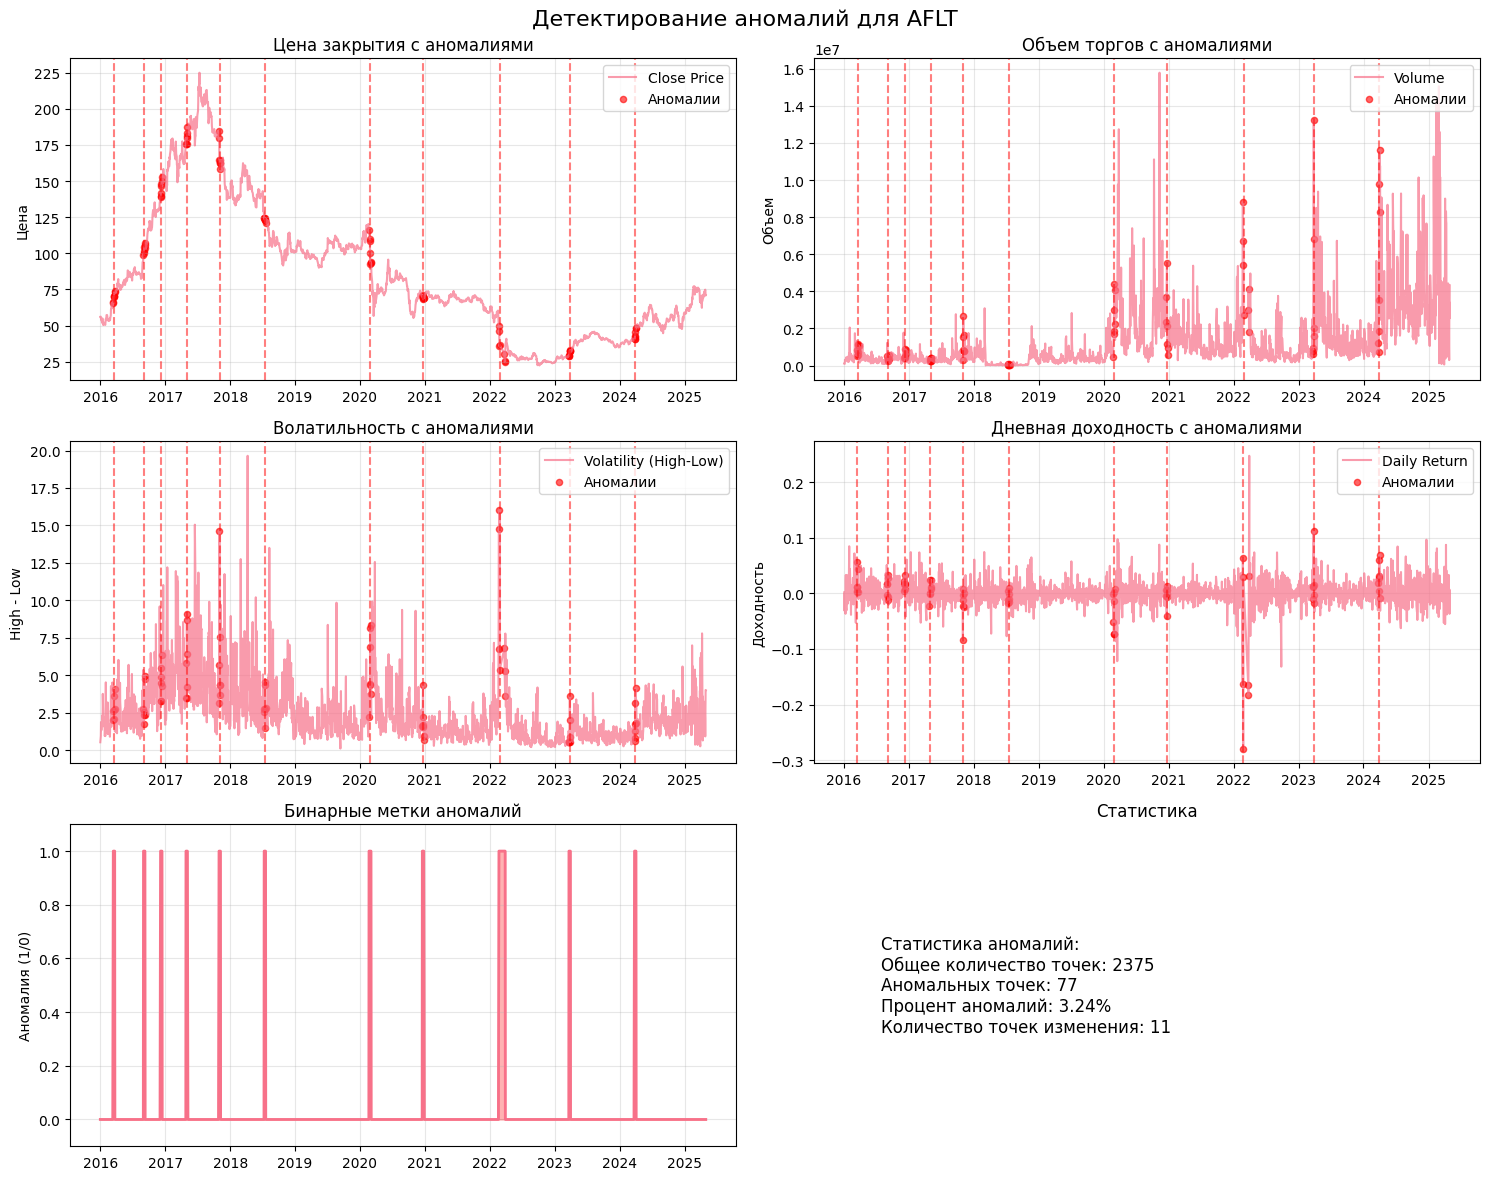

  Результат сохранен в ../data/series_with_anomaly/AFLT_with_anomalies.csv

Обработка LKOH...
  Метод: pelt, Модель: l2
    Найдено 45 точек изменения
    Процент аномалий: 13.26%
  Метод: pelt, Модель: rbf
    Найдено 11 точек изменения
    Процент аномалий: 3.24%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Выбран лучший результат: pelt_rbf


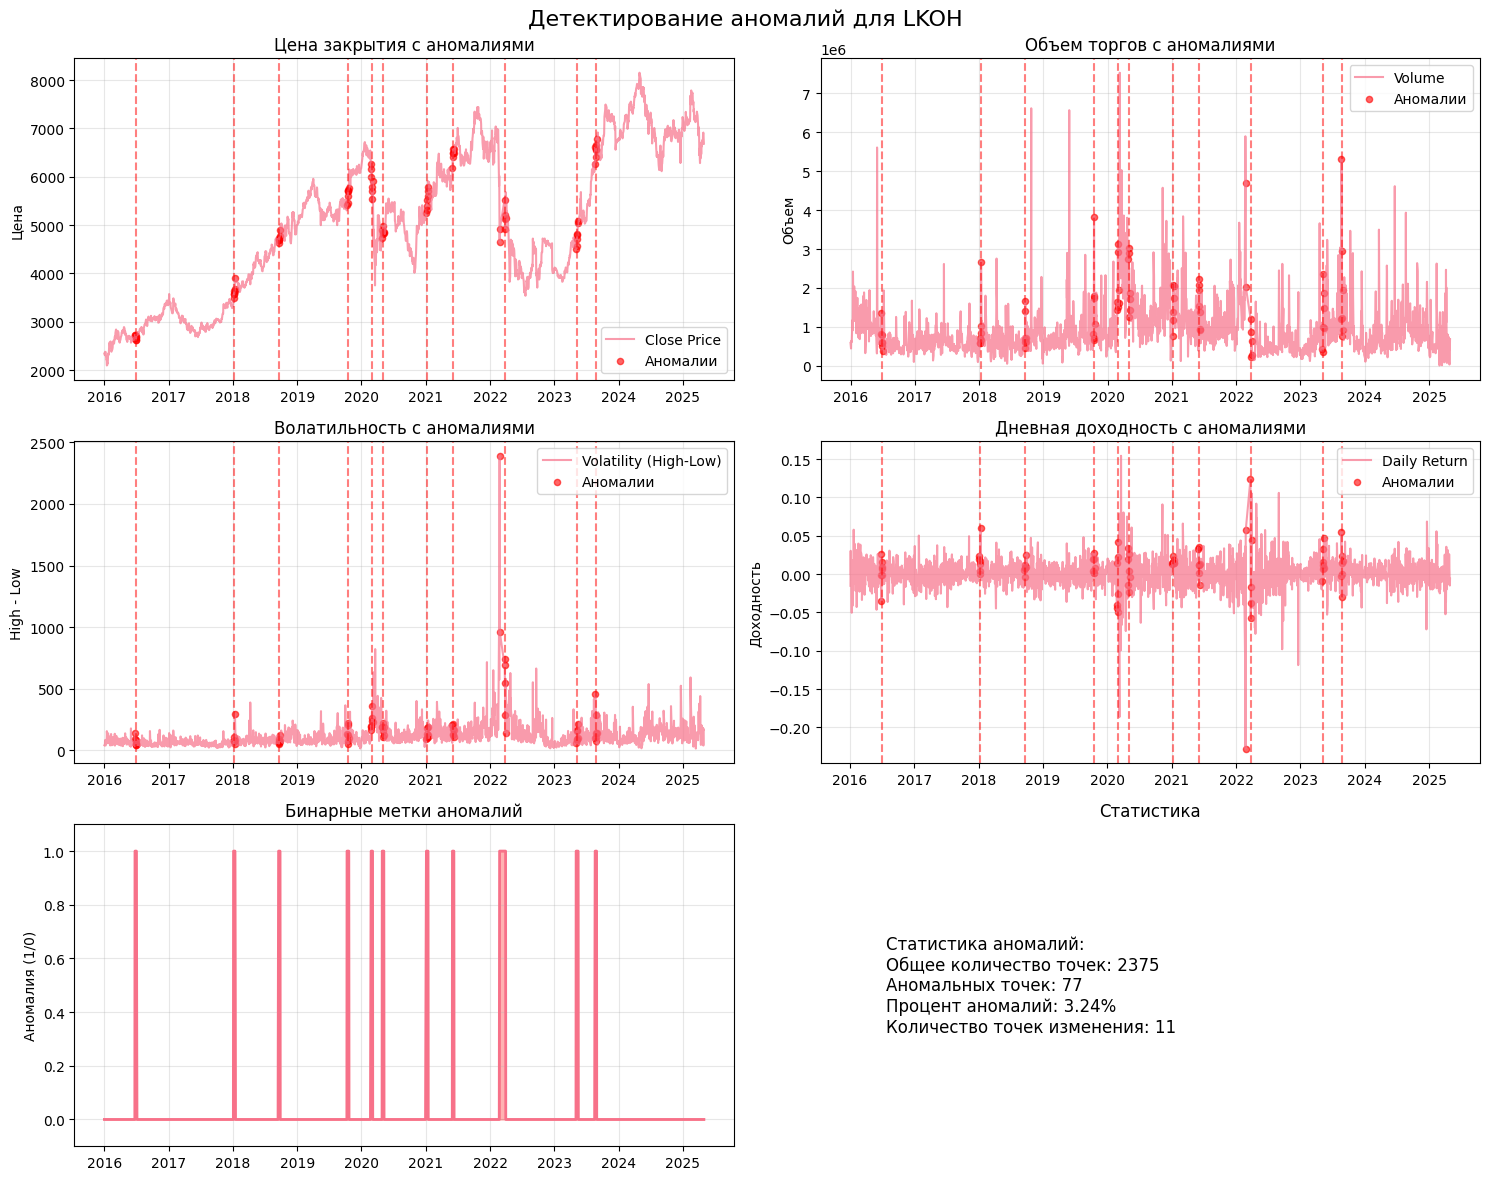

  Результат сохранен в ../data/series_with_anomaly/LKOH_with_anomalies.csv

Обработка MOEX...
  Метод: pelt, Модель: l2
    Найдено 38 точек изменения
    Процент аномалий: 11.20%
  Метод: pelt, Модель: rbf
    Найдено 14 точек изменения
    Процент аномалий: 4.13%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Выбран лучший результат: pelt_rbf


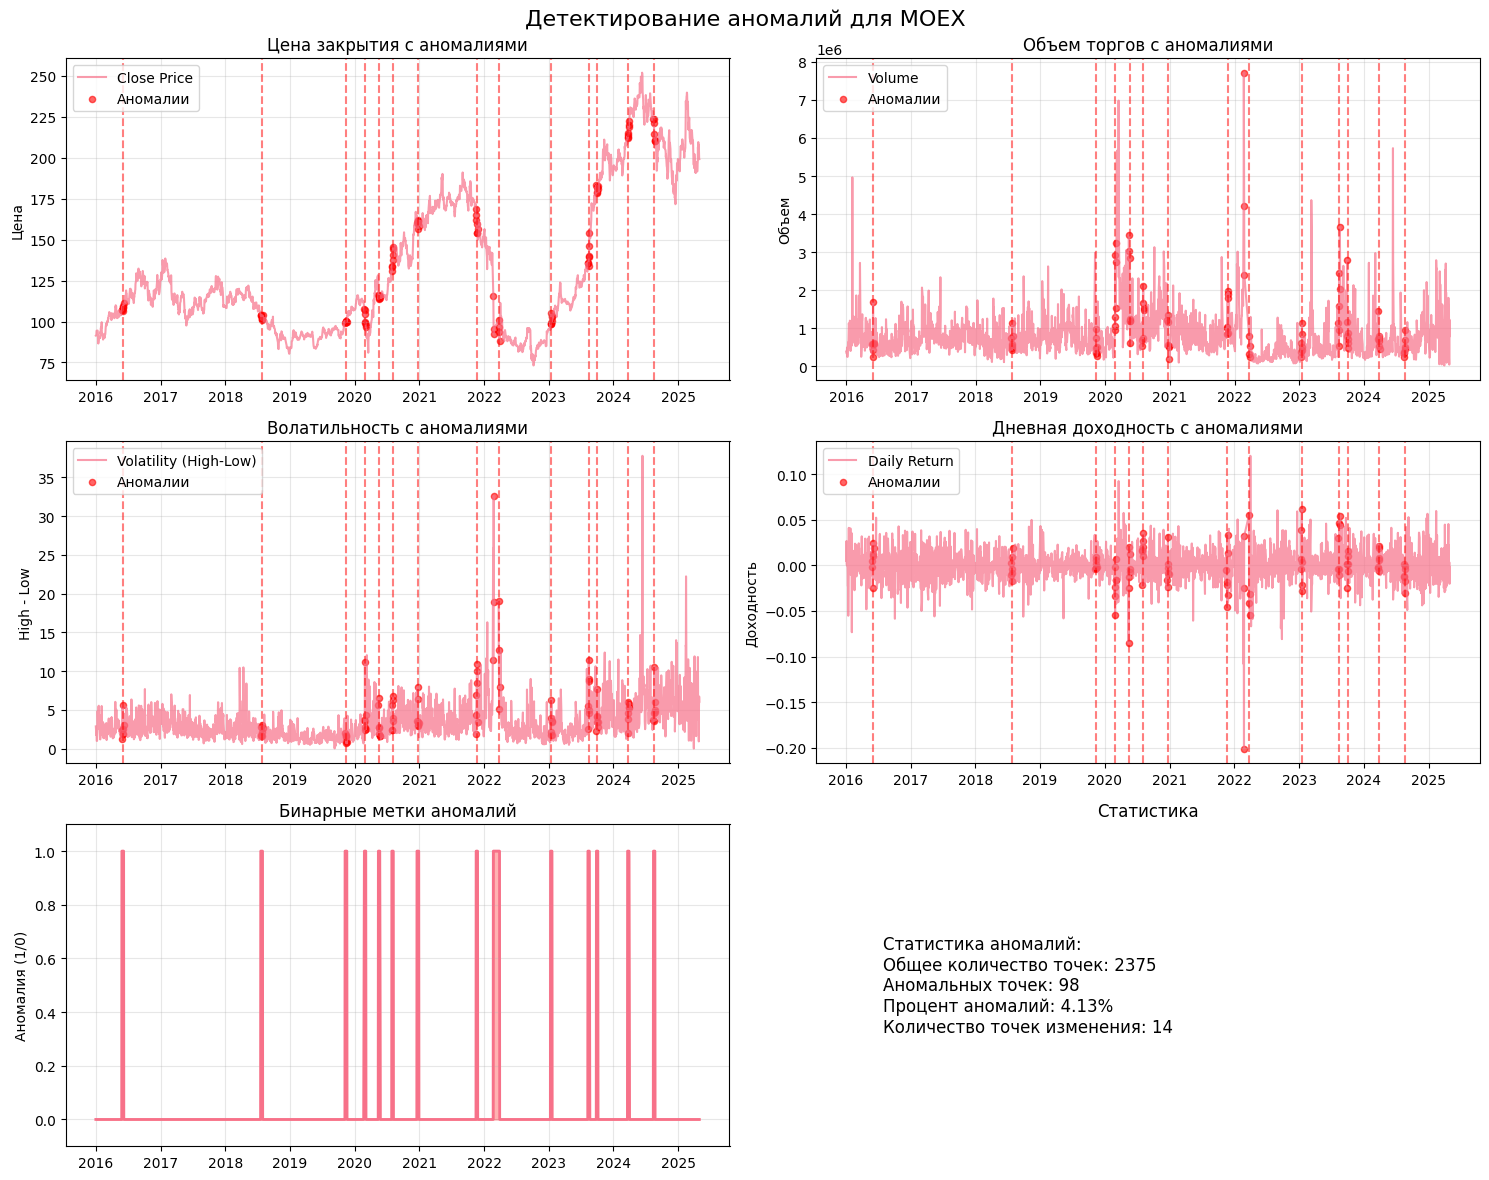

  Результат сохранен в ../data/series_with_anomaly/MOEX_with_anomalies.csv

Обработка NVTK...
  Метод: pelt, Модель: l2
    Найдено 41 точек изменения
    Процент аномалий: 12.09%
  Метод: pelt, Модель: rbf
    Найдено 13 точек изменения
    Процент аномалий: 3.83%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Выбран лучший результат: pelt_rbf


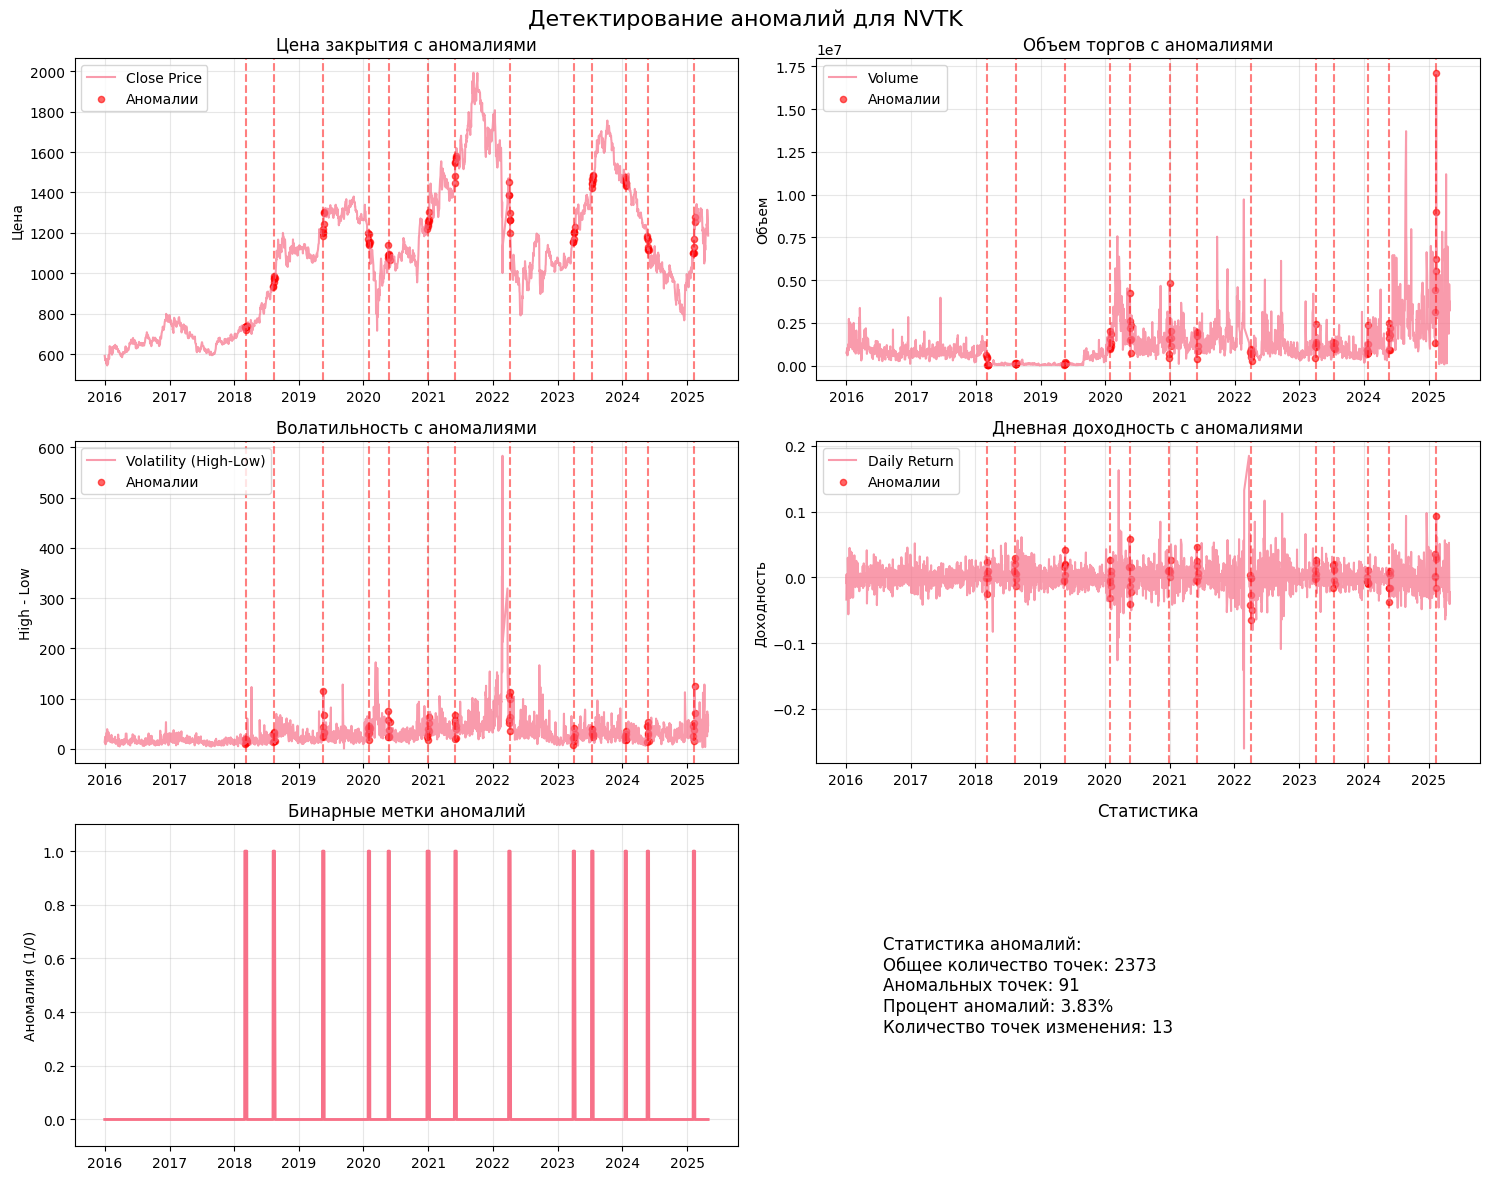

  Результат сохранен в ../data/series_with_anomaly/NVTK_with_anomalies.csv

Обработка PIKK...
  Метод: pelt, Модель: l2
    Найдено 25 точек изменения
    Процент аномалий: 7.37%
  Метод: pelt, Модель: rbf
    Найдено 18 точек изменения
    Процент аномалий: 5.31%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Выбран лучший результат: pelt_rbf


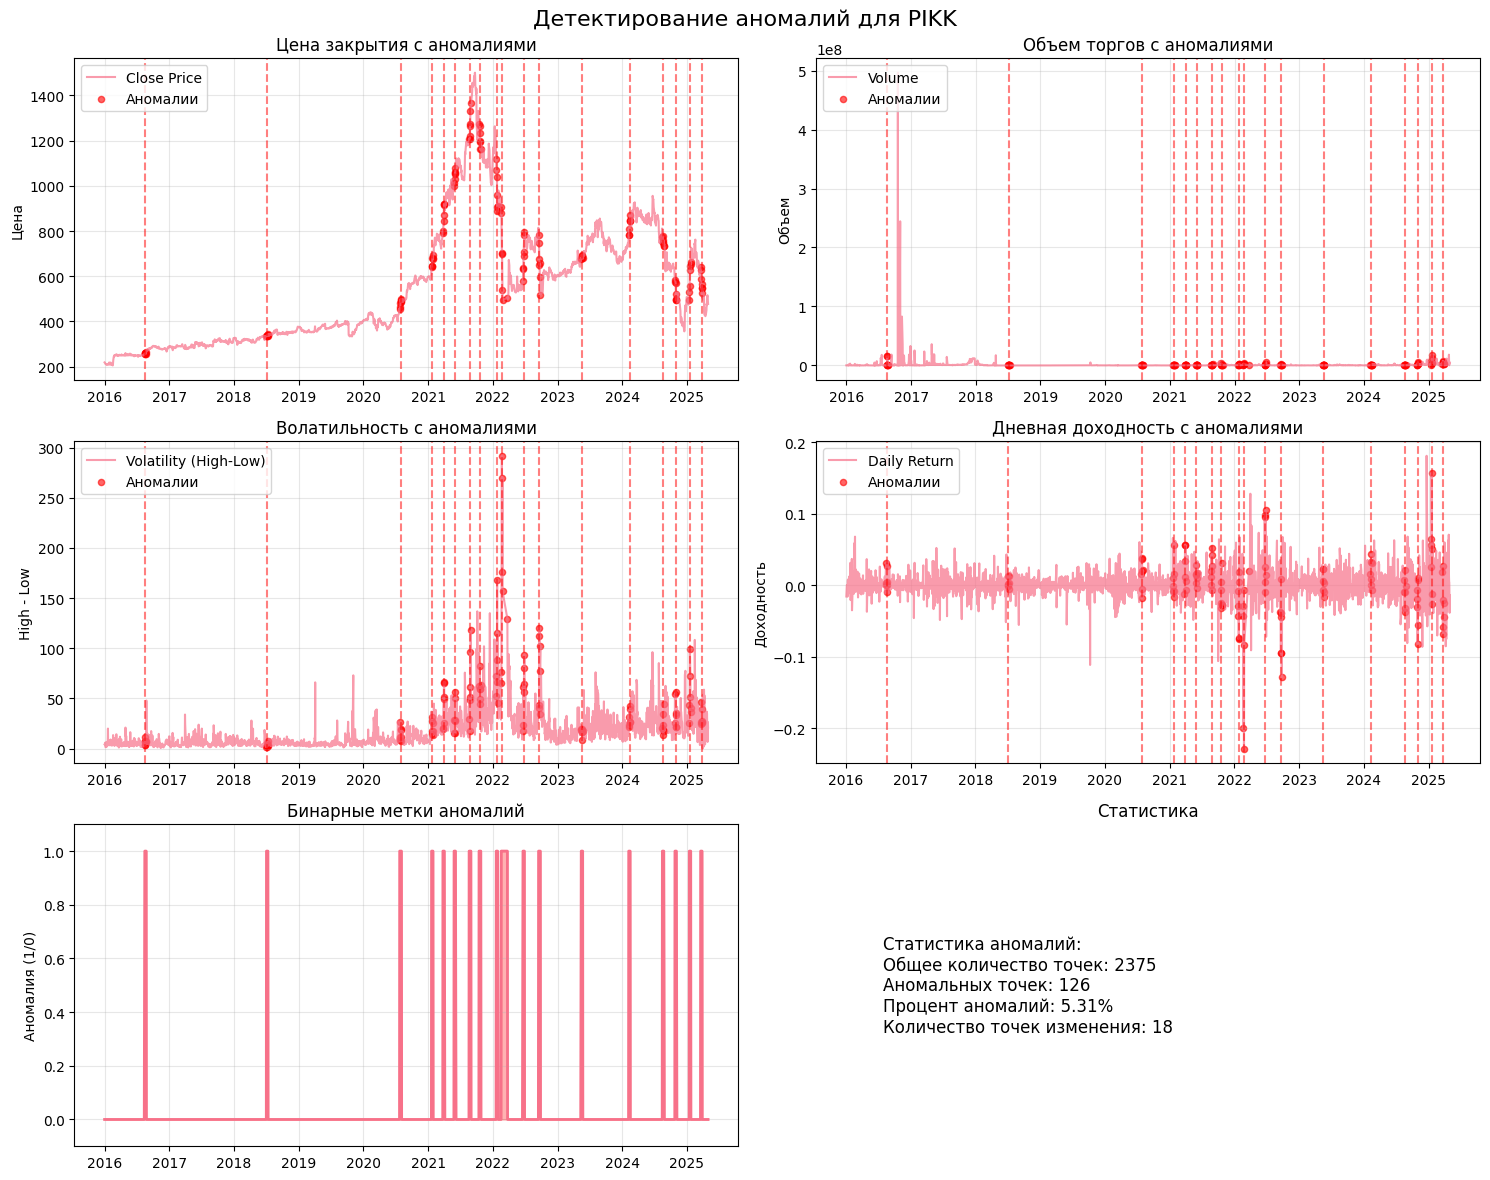

  Результат сохранен в ../data/series_with_anomaly/PIKK_with_anomalies.csv

Обработка SBER...
  Метод: pelt, Модель: l2
    Найдено 38 точек изменения
    Процент аномалий: 11.20%
  Метод: pelt, Модель: rbf
    Найдено 20 точек изменения
    Процент аномалий: 5.89%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 2.95%
  Выбран лучший результат: pelt_rbf


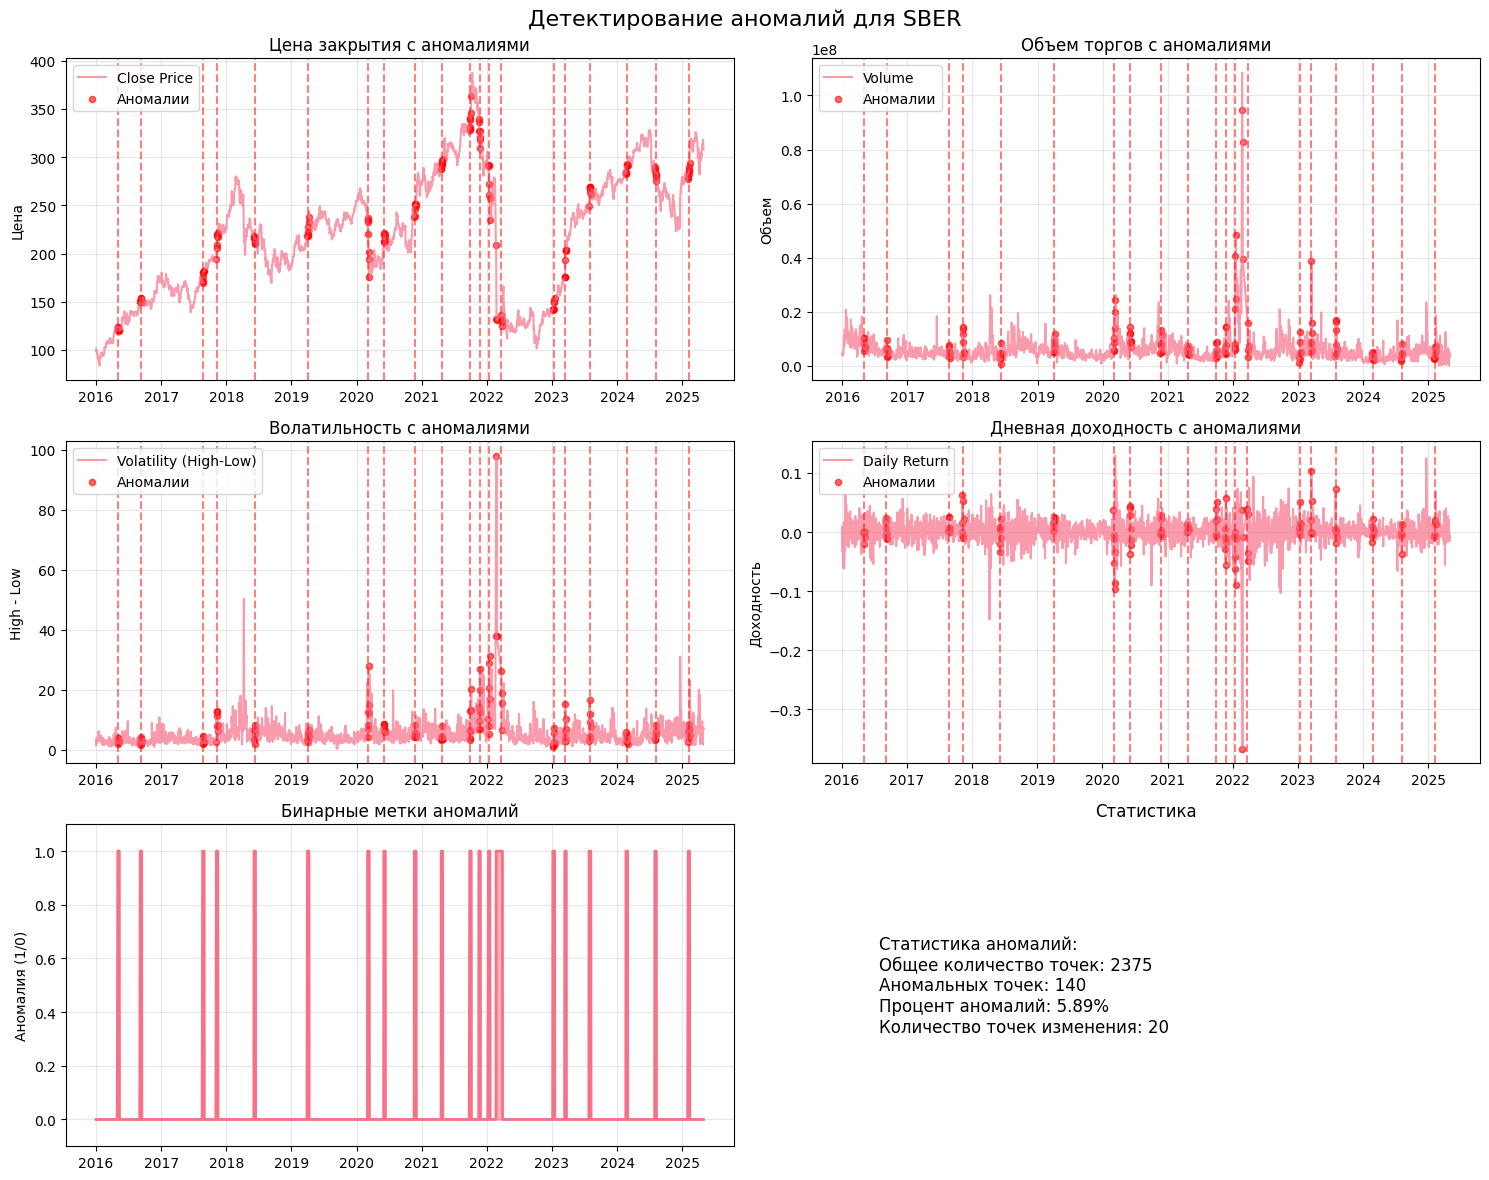

  Результат сохранен в ../data/series_with_anomaly/SBER_with_anomalies.csv

Обработка VKCO...
  Метод: pelt, Модель: l2
    Найдено 17 точек изменения
    Процент аномалий: 9.94%
  Метод: pelt, Модель: rbf
    Найдено 5 точек изменения
    Процент аномалий: 2.92%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 5.85%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 5.85%
  Выбран лучший результат: binseg_l2


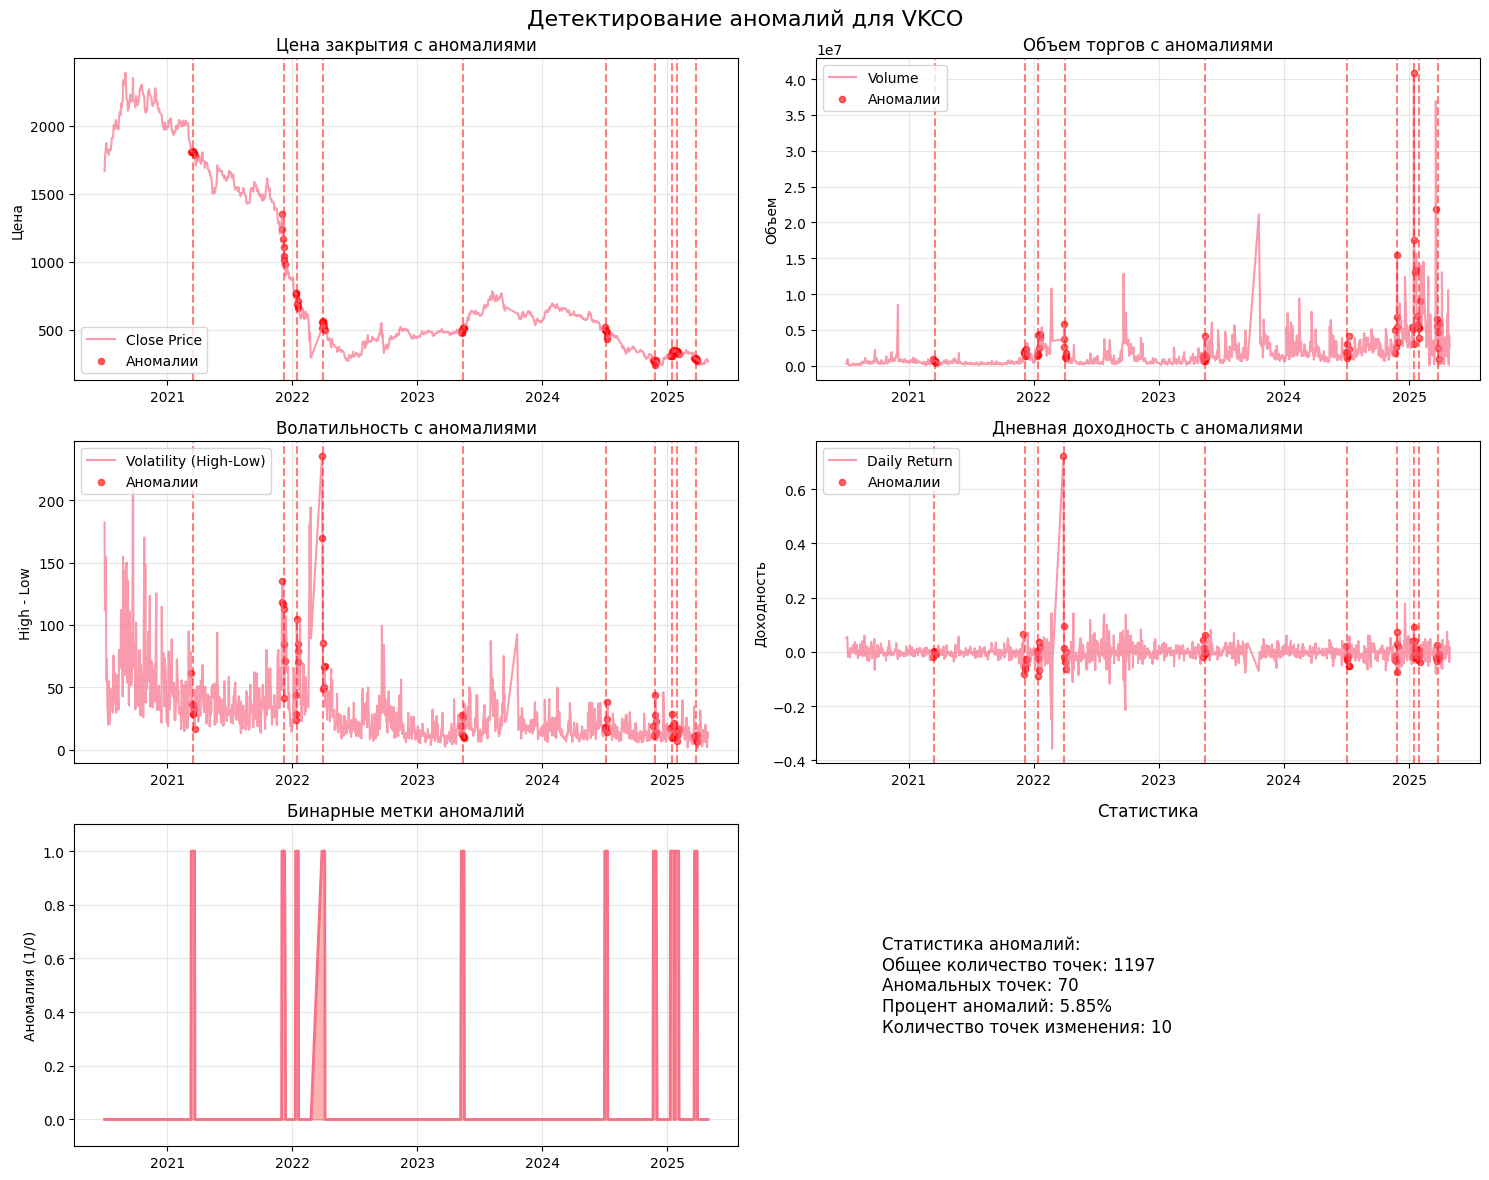

  Результат сохранен в ../data/series_with_anomaly/VKCO_with_anomalies.csv

Обработка VTBR...
  Метод: pelt, Модель: l2
    Найдено 22 точек изменения
    Процент аномалий: 8.94%
  Метод: pelt, Модель: rbf
    Найдено 9 точек изменения
    Процент аномалий: 3.66%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 4.07%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 4.07%
  Выбран лучший результат: binseg_l2


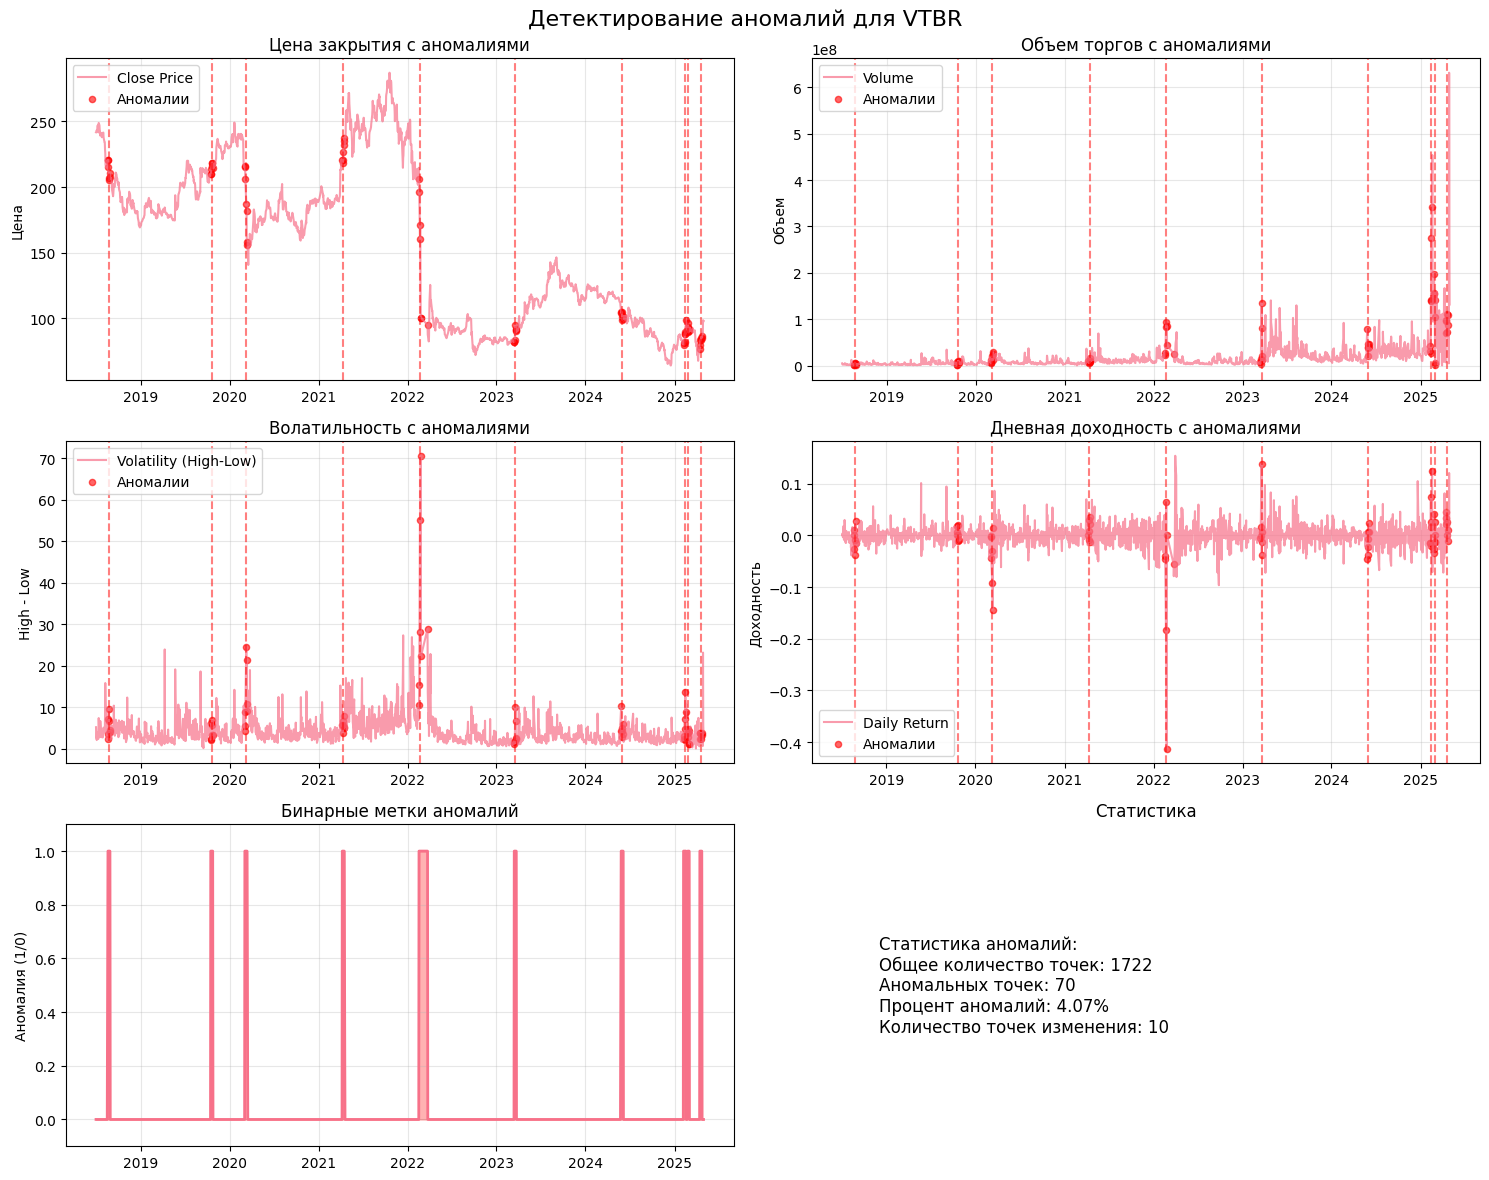

  Результат сохранен в ../data/series_with_anomaly/VTBR_with_anomalies.csv

Обработка X5...
  Метод: pelt, Модель: l2
    Найдено 26 точек изменения
    Процент аномалий: 12.14%
  Метод: pelt, Модель: rbf
    Найдено 9 точек изменения
    Процент аномалий: 4.20%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 4.67%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 4.67%
  Выбран лучший результат: binseg_l2


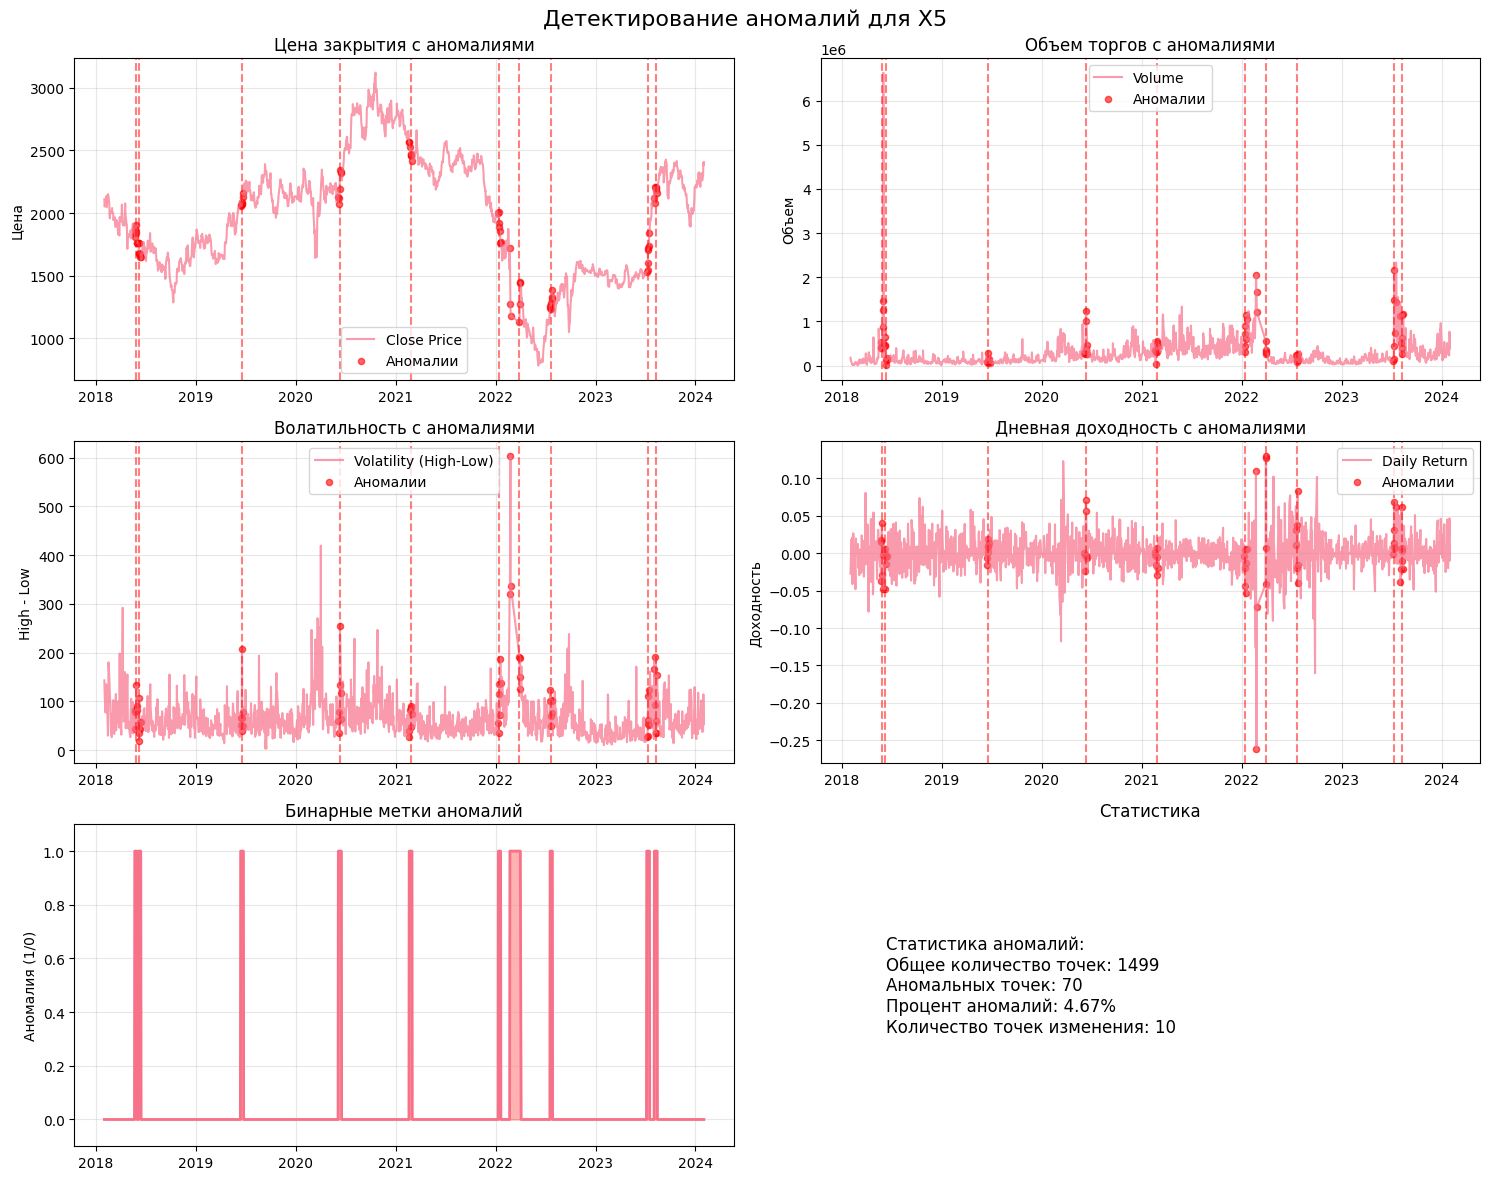

  Результат сохранен в ../data/series_with_anomaly/X5_with_anomalies.csv

Обработка YDEX...
  Метод: pelt, Модель: l2
    Найдено 28 точек изменения
    Процент аномалий: 8.38%
  Метод: pelt, Модель: rbf
    Найдено 14 точек изменения
    Процент аномалий: 4.19%
  Метод: binseg, Модель: l2
    Найдено 10 точек изменения
    Процент аномалий: 2.99%
  Метод: binseg, Модель: rbf
    Найдено 10 точек изменения
    Процент аномалий: 2.99%
  Выбран лучший результат: pelt_rbf


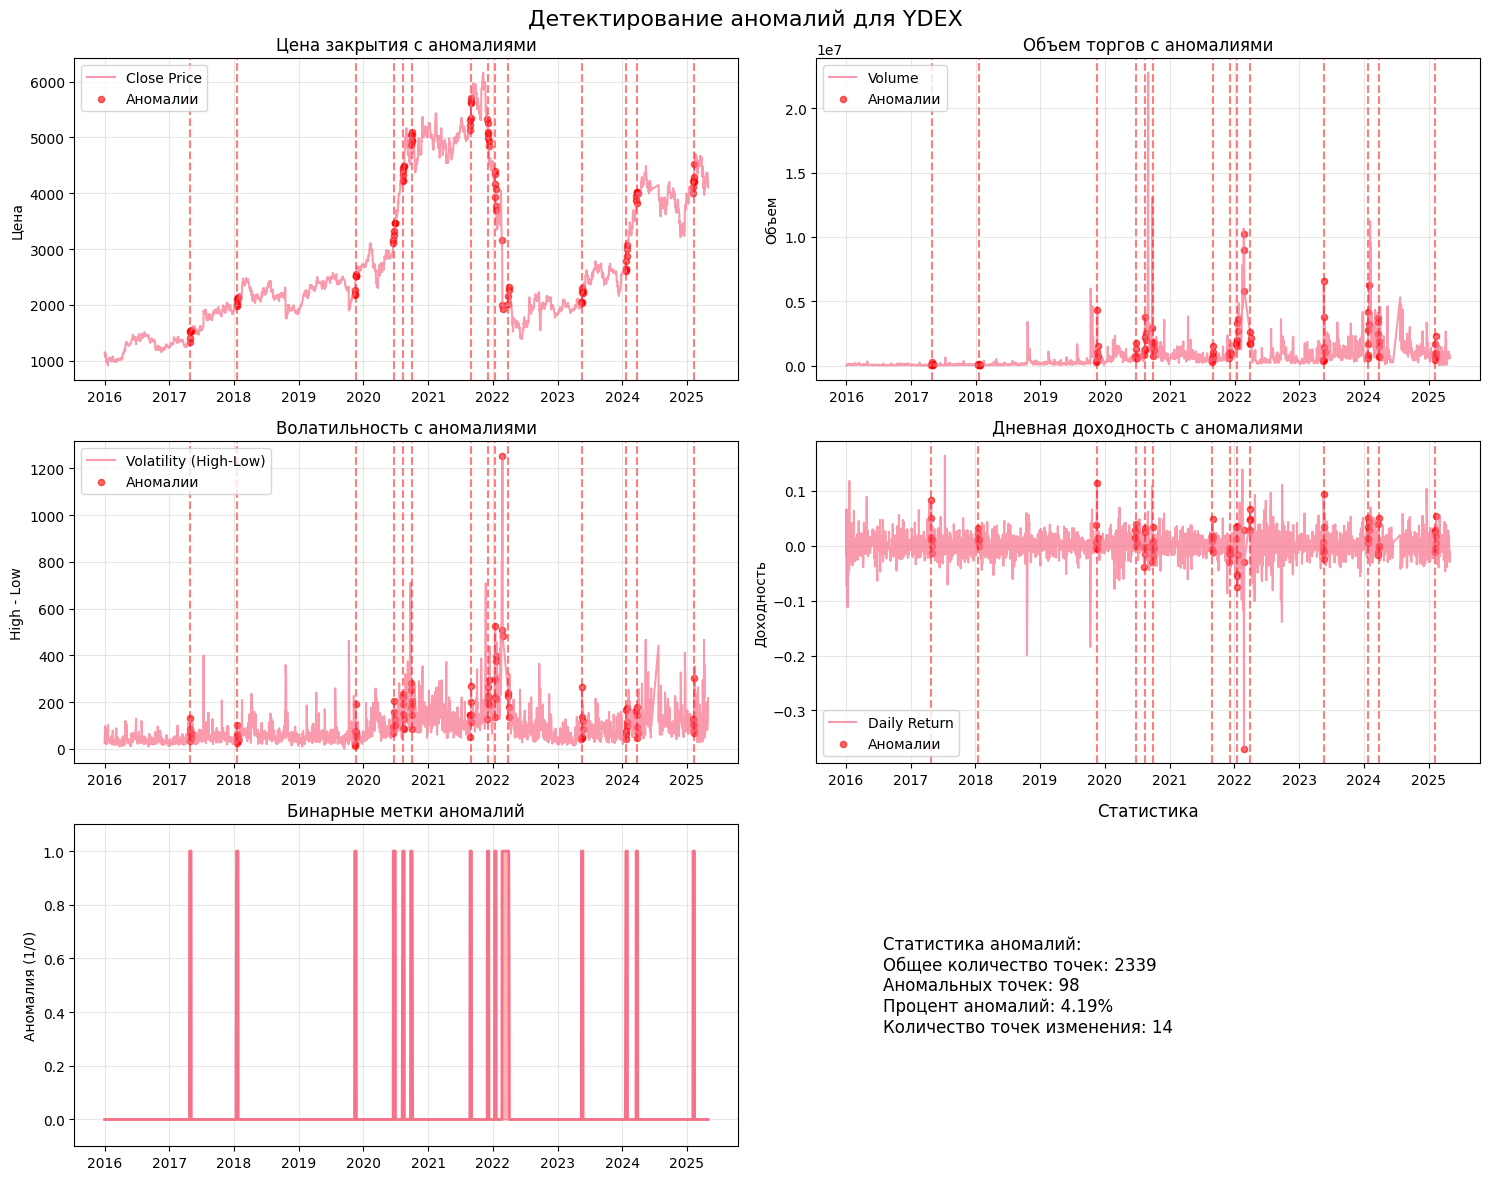

  Результат сохранен в ../data/series_with_anomaly/YDEX_with_anomalies.csv


In [6]:
# Обрабатываем все файлы
all_results = []

for file_path in csv_files:
    result = process_time_series(file_path)
    if result:
        all_results.append(result)


## Сводка результатов



СВОДКА РЕЗУЛЬТАТОВ ДЕТЕКТИРОВАНИЯ АНОМАЛИЙ
ticker    method  change_points_count  anomaly_percentage  data_length
  AFLT  pelt_rbf                   11            3.242105         2375
  LKOH  pelt_rbf                   11            3.242105         2375
  MOEX  pelt_rbf                   14            4.126316         2375
  NVTK  pelt_rbf                   13            3.834808         2373
  PIKK  pelt_rbf                   18            5.305263         2375
  SBER  pelt_rbf                   20            5.894737         2375
  VKCO binseg_l2                   10            5.847953         1197
  VTBR binseg_l2                   10            4.065041         1722
    X5 binseg_l2                   10            4.669780         1499
  YDEX  pelt_rbf                   14            4.189825         2339

Сводка сохранена в ../data/series_with_anomaly/anomaly_detection_summary.csv

Статистика использованных методов:
method
pelt_rbf     7
binseg_l2    3
Name: count, dtype: int6

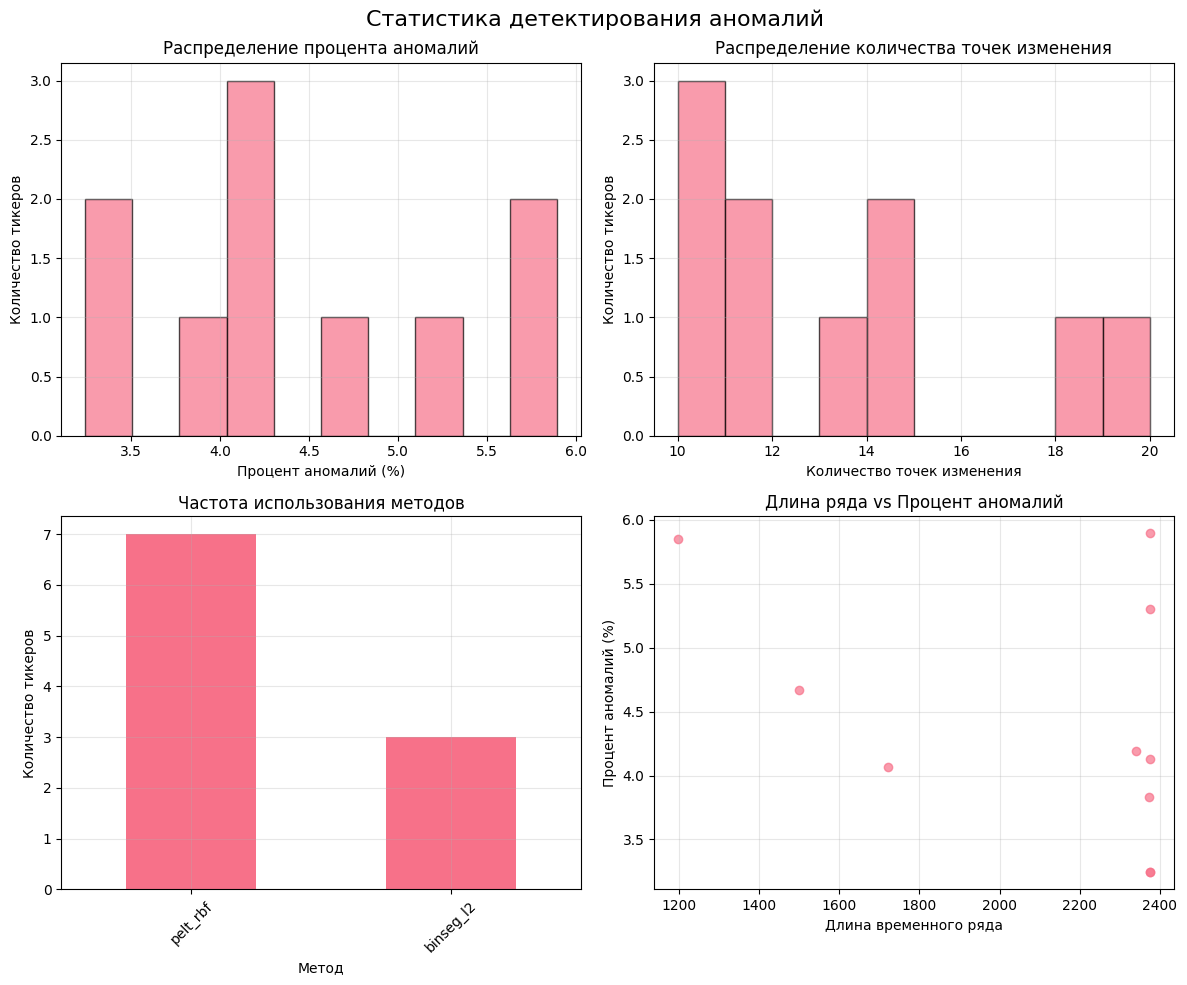

In [7]:
# Создаем сводную таблицу результатов
if all_results:
    summary_df = pd.DataFrame(all_results)
    
    print("\n" + "="*60)
    print("СВОДКА РЕЗУЛЬТАТОВ ДЕТЕКТИРОВАНИЯ АНОМАЛИЙ")
    print("="*60)
    print(summary_df.to_string(index=False))
    
    # Сохраняем сводку
    summary_file = output_path / "anomaly_detection_summary.csv"
    summary_df.to_csv(summary_file, index=False)
    print(f"\nСводка сохранена в {summary_file}")
    
    # Статистика методов
    print("\nСтатистика использованных методов:")
    method_counts = summary_df['method'].value_counts()
    print(method_counts)
    
    # Общая статистика
    print("\nОбщая статистика:")
    print(f"Среднее количество точек изменения: {summary_df['change_points_count'].mean():.1f}")
    print(f"Средний процент аномалий: {summary_df['anomaly_percentage'].mean():.2f}%")
    print(f"Средняя длина временного ряда: {summary_df['data_length'].mean():.0f} точек")
    
    # Визуализация статистики
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Статистика детектирования аномалий', fontsize=16)
    
    # Распределение процента аномалий
    axes[0, 0].hist(summary_df['anomaly_percentage'], bins=10, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Распределение процента аномалий')
    axes[0, 0].set_xlabel('Процент аномалий (%)')
    axes[0, 0].set_ylabel('Количество тикеров')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Распределение количества точек изменения
    axes[0, 1].hist(summary_df['change_points_count'], bins=10, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Распределение количества точек изменения')
    axes[0, 1].set_xlabel('Количество точек изменения')
    axes[0, 1].set_ylabel('Количество тикеров')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Использование методов
    method_counts.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Частота использования методов')
    axes[1, 0].set_xlabel('Метод')
    axes[1, 0].set_ylabel('Количество тикеров')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Связь между длиной ряда и процентом аномалий
    axes[1, 1].scatter(summary_df['data_length'], summary_df['anomaly_percentage'], alpha=0.7)
    axes[1, 1].set_title('Длина ряда vs Процент аномалий')
    axes[1, 1].set_xlabel('Длина временного ряда')
    axes[1, 1].set_ylabel('Процент аномалий (%)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Не удалось обработать ни одного файла.")


## Заключение

В этом ноутбуке мы использовали библиотеку Ruptures для детектирования аномалий в многомерных временных рядах финансовых данных. 

**Основные этапы:**
1. Загрузка и предобработка данных OHLCV
2. Применение различных алгоритмов детектирования точек изменения (PELT, Binary Segmentation)
3. Использование разных моделей (L2, RBF) для обнаружения изменений
4. Создание бинарных меток аномалий на основе точек изменения
5. Визуализация результатов и сохранение данных с аномалиями

**Преимущества подхода:**
- Работает с многомерными данными
- Не требует обучения на размеченных данных
- Гибкость в выборе методов и моделей
- Интерпретируемые результаты

**Результаты сохранены в:**
- Папка `../data/series_with_anomaly/` содержит файлы с размеченными аномалиями
- Файл `anomaly_detection_summary.csv` содержит сводку по всем обработанным тикерам
